In [1]:
from bs4 import BeautifulSoup
import lxml
import requests
from urllib.robotparser import RobotFileParser
from requests.compat import urlparse, urljoin
from requests.exceptions import HTTPError
from requests import request
from requests.compat import urljoin, urlparse
import time
from time import sleep
import sqlite3
import re

In [2]:
def canfetch(url, agent='*', path='/'):
    robot = RobotFileParser(urljoin(url, '/robots.txt'))
    robot.read()
    return robot.can_fetch(agent, urlparse(url)[2]) ## 가져올 수 있으면 True

def download(url, params={}, headers={}, method='GET', limit=3):
    method = method.upper()
    if canfetch(url) == False:
        print('[Error] ' + url)
#     else: # 실제 수집할 때, 제약사항이 많으므로 여기선 잠시 해제
    try:
        resp = request(method, url,
               params=params if method=='GET' else {},
               data=params if method=='POST' else {},
               headers=headers)
        resp.raise_for_status()
    except HTTPError as e:
        if limit > 0 and e.response.status_code >= 500:
            print(limit)
            time.sleep(1) # => random
            resp = download(url, params, headers, method, limit-1)
        else:
            print('[{}] '.format(e.response.status_code) + url)
            print(e.response.status_code)
            print(e.response.reason)
            print(e.response.headers)
    return resp

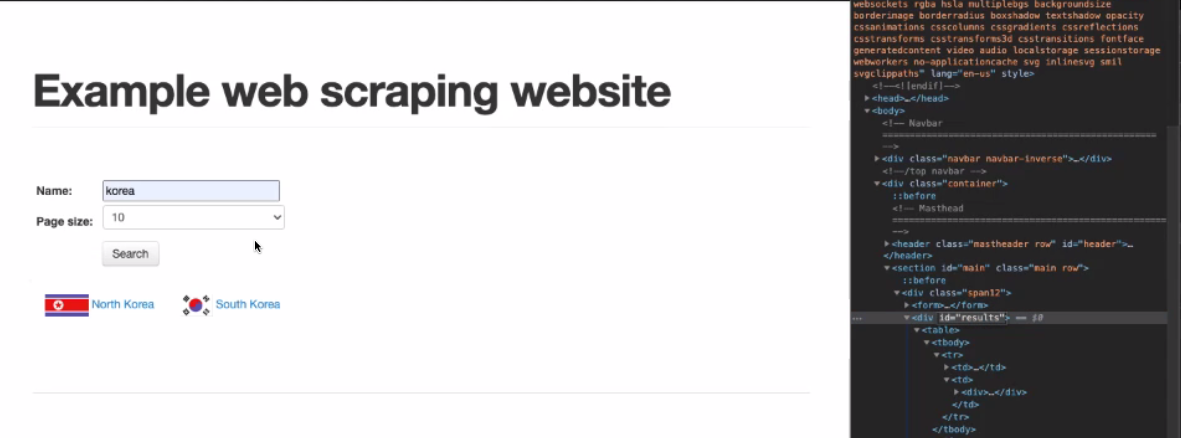

In [3]:
url = 'http://example.webscraping.com/places/default/search'

In [4]:
resp = download(url)
dom = BeautifulSoup(resp.text, 'html.parser')

In [5]:
## 전체를 감싸고 있는 부분 찾기
# Signature: dom.find(name=None, attrs={}, recursive=True, text=None, **kwargs)
# Docstring:
# Return only the first child of this Tag matching the given criteria.
dom.find('div', {'id' : 'results'})

<div id="results">
</div>

In [6]:
# <from action=주소>?search_term=국가명&page_size=10

## form tag 부분의 Javascript부분 찾아보려고 해보기
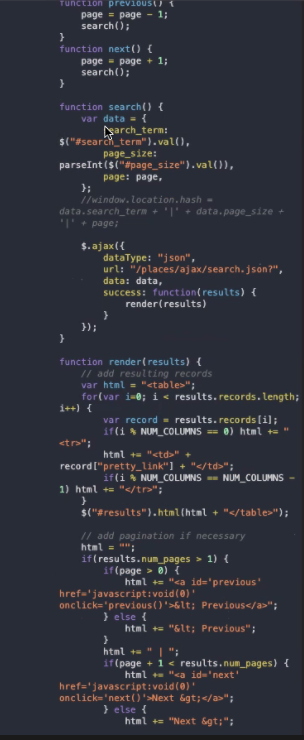

In [7]:
# Signature: dom.select_one(selector)
# Docstring: Perform a CSS selection operation on the current element.
dom.select_one('#search'), dom.select_one('form')
## Home tag의
# <from action=주소>?
# search_term=국가명&page_size=10&page=0 : 필요 parameters

(<input id="search" type="submit" value="Search"/>,
 <form>
 <table>
 <tr>
 <th>Name:</th>
 <td><input id="search_term"/></td>
 </tr>
 <tr>
 <th>Page size:</th>
 <td>
 <select id="page_size">
 <option>4</option>
 <option selected="">10</option>
 <option>20</option>
 </select>
 </td>
 </tr>
 <tr>
 <td></td>
 <td>
 <input id="search" type="submit" value="Search"/>
 </td>
 </tr>
 </table>
 </form>)

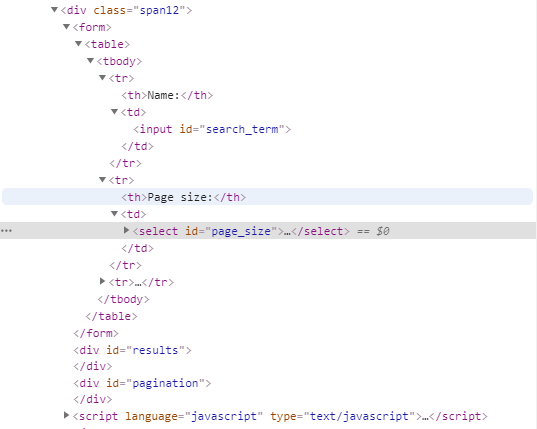

In [10]:
ajax = '/places/ajax/search.json'
params = {
    'search_term' : 'korea',
    'page_size': 10,
    'page' : 0
}
resp=download(urljoin(url, ajax), params = params)

In [11]:
resp.status_code, resp.reason, resp.headers

(200,
 'OK',
 {'Server': 'nginx', 'Date': 'Wed, 05 Aug 2020 11:40:32 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Vary': 'Accept-Encoding', 'X-Powered-By': 'web2py', 'Set-Cookie': 'session_id_places=True; httponly; Path=/', 'Expires': 'Wed, 05 Aug 2020 11:40:32 GMT', 'Pragma': 'no-cache', 'Cache-Control': 'no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Content-Encoding': 'gzip'})

In [12]:
result = resp.json() # json 변환

In [13]:
result

{'records': [{'pretty_link': '<div><a href="/places/default/view/North-Korea-165"><img src="/places/static/images/flags/kp.png" /> North Korea</a></div>',
   'country': 'North Korea',
   'id': 6817773},
  {'pretty_link': '<div><a href="/places/default/view/South-Korea-211"><img src="/places/static/images/flags/kr.png" /> South Korea</a></div>',
   'country': 'South Korea',
   'id': 6817819}],
 'num_pages': 1,
 'error': ''}

In [17]:
result['records'], result['records'][1] # 우리나라

([{'pretty_link': '<div><a href="/places/default/view/North-Korea-165"><img src="/places/static/images/flags/kp.png" /> North Korea</a></div>',
   'country': 'North Korea',
   'id': 6817773},
  {'pretty_link': '<div><a href="/places/default/view/South-Korea-211"><img src="/places/static/images/flags/kr.png" /> South Korea</a></div>',
   'country': 'South Korea',
   'id': 6817819}],
 {'pretty_link': '<div><a href="/places/default/view/South-Korea-211"><img src="/places/static/images/flags/kr.png" /> South Korea</a></div>',
  'country': 'South Korea',
  'id': 6817819})

In [38]:
for _ in result['records']:
    print(_['id'])
    print(_['country'])
    print(_['pretty_link'], end='\n\n')
    print()
    ## 정규식으로 가져와보자
    print(urljoin(url, re.search(r'href="([^"]+)"', _['pretty_link']).group(1)))
    print(urljoin(url, re.search(r'src="([^"]+)"', _['pretty_link']).group(1)))
    print(re.search(r'>\s*([^<]+)<', _['pretty_link']).group(1), end = '\n')
    print()
    
    dom = BeautifulSoup(_['pretty_link'], 'html.parser')
    print(urljoin(url, dom.a['href']))
    print(urljoin(url, dom.img['src']))
    print(dom.a.text.strip())
    print()

6817773
North Korea
<div><a href="/places/default/view/North-Korea-165"><img src="/places/static/images/flags/kp.png" /> North Korea</a></div>


http://example.webscraping.com/places/default/view/North-Korea-165
http://example.webscraping.com/places/static/images/flags/kp.png
North Korea

http://example.webscraping.com/places/default/view/North-Korea-165
http://example.webscraping.com/places/static/images/flags/kp.png
North Korea

6817819
South Korea
<div><a href="/places/default/view/South-Korea-211"><img src="/places/static/images/flags/kr.png" /> South Korea</a></div>


http://example.webscraping.com/places/default/view/South-Korea-211
http://example.webscraping.com/places/static/images/flags/kr.png
South Korea

http://example.webscraping.com/places/default/view/South-Korea-211
http://example.webscraping.com/places/static/images/flags/kr.png
South Korea



In [18]:
## search 관련된 부분 누를 때 무엇이 동작하는지
## network 부분으로 가서 xml filtering해서 찾기

In [19]:
url = 'http://pythonscraping.com/pages/cookies/login.html'
resp = download(url)
dom = BeautifulSoup(resp.text, 'html.parser')
dom.form

<form action="welcome.php" method="post">
Username (use anything!): <input name="username" type="text"/><br/>
Password (try "password"): <input name="password" type="password"/><br/>
<input type="submit" value="Login"/>
</form>

In [20]:
urljoin(url, dom.form['action'])

'http://pythonscraping.com/pages/cookies/welcome.php'

In [21]:
dom.select('input[name]')  # params = username=이름&password=비밀번호

# download(urljoin(url, dom.form['action']), params=, method='POST')

[<input name="username" type="text"/>,
 <input name="password" type="password"/>]

In [22]:

params = {}
for _ in dom.select('input[name]'):
    params[_['name']] = 'anything' if _['name']=='username' else 'password'
    
resp = download(urljoin(url, dom.form['action']), params=params, method='POST')

In [23]:
resp.request.headers, resp.request.body # 보낸 값 확인

({'User-Agent': 'python-requests/2.24.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'Content-Length': '35', 'Content-Type': 'application/x-www-form-urlencoded'},
 'username=anything&password=password')

In [24]:
resp.text # 응답

'\n<h2>Welcome to the Website!</h2>\nWhoops! You logged in wrong. Try again with any username, and the password "password"<br><a href="login.html">Log in here</a>'

In [25]:
## cookie!
# request(쿠키x) == session(쿠키o) : 쓰는 방법 ==
from requests import Session


In [26]:
session = Session()

In [27]:
session.request('POST', urljoin(url, dom.form['action']), data=params)

<Response [200]>

In [28]:
resp.request.headers, resp.request.body 

({'User-Agent': 'python-requests/2.24.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'Content-Length': '35', 'Content-Type': 'application/x-www-form-urlencoded'},
 'username=anything&password=password')

In [29]:
resp.text

'\n<h2>Welcome to the Website!</h2>\nWhoops! You logged in wrong. Try again with any username, and the password "password"<br><a href="login.html">Log in here</a>'

In [30]:
resp.cookies.get_dict() # 정상적으로 로그인이 된 상태

{'loggedin': '1', 'username': 'anything'}

In [31]:
## 다녀온 후에 다시 페이지를 요청하면 로그인이 되는 모습을 확인할 수 있다
resp = session.request('GET', urljoin(url, dom.form['action']))
resp.text

'\n<h2>Welcome to the Website!</h2>\nYou have logged in successfully! <br><a href="profile.php">Check out your profile!</a>'

In [32]:
# request로는 안 되는 모습
resp = request('GET', urljoin(url, dom.form['action']))
resp.text

'\n<h2>Welcome to the Website!</h2>\nWhoops! You logged in wrong. Try again with any username, and the password "password"<br><a href="login.html">Log in here</a>'

In [33]:
session.cookies

<RequestsCookieJar[Cookie(version=0, name='loggedin', value='1', port=None, port_specified=False, domain='pythonscraping.com', domain_specified=False, domain_initial_dot=False, path='/pages/cookies', path_specified=False, secure=False, expires=None, discard=True, comment=None, comment_url=None, rest={}, rfc2109=False), Cookie(version=0, name='username', value='anything', port=None, port_specified=False, domain='pythonscraping.com', domain_specified=False, domain_initial_dot=False, path='/pages/cookies', path_specified=False, secure=False, expires=None, discard=True, comment=None, comment_url=None, rest={}, rfc2109=False)]>

In [34]:
# cookie 같이 넘기면 성공
resp = request('GET', urljoin(url, dom.form['action']), cookies=session.cookies)
resp.text

'\n<h2>Welcome to the Website!</h2>\nYou have logged in successfully! <br><a href="profile.php">Check out your profile!</a>'

In [35]:
session.cookies.items()

[('loggedin', '1'), ('username', 'anything')]

In [36]:
cookiedict = {}
for _ in session.cookies.items():
    cookiedict[_[0]] = _[1]
cookiedict

{'loggedin': '1', 'username': 'anything'}

In [37]:
## 네이버 로그인창
headers = {
    'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'
}
resp = download('https://nid.naver.com/nidlogin.login?mode=form&url=https%3A%2F%2Fwww.naver.com', headers=headers)
dom = BeautifulSoup(resp.text, 'html.parser')

[Error] https://nid.naver.com/nidlogin.login?mode=form&url=https%3A%2F%2Fwww.naver.com


In [38]:
dom.form

<form action="https://nid.naver.com/nidlogin.login" autocomplete="off" id="frmNIDLogin" method="POST" name="frmNIDLogin" target="_top">
<input id="localechange" name="localechange" type="hidden" value=""/>
<input id="encpw" name="encpw" type="hidden" value=""/>
<input id="enctp" name="enctp" type="hidden" value="1"/>
<input id="svctype" name="svctype" type="hidden" value="1"/>
<input id="smart_LEVEL" name="smart_LEVEL" type="hidden" value="1"/>
<input id="bvsd" name="bvsd" type="hidden" value=""/>
<input id="encnm" name="encnm" type="hidden" value=""/>
<input id="locale" name="locale" type="hidden" value="ko_KR"/>
<input id="url" name="url" type="hidden" value="https://www.naver.com"/>
<fieldset class="login_form">
<legend class="blind">로그인</legend>
<div class="id_area">
<div class="input_row" id="id_area">
<span class="input_box">
<label class="lbl" for="id" id="label_id_area">아이디</label>
<input accesskey="L" class="int" id="id" maxlength="41" name="id" placeholder="아이디" type="text" v

In [39]:
params = dict()
for _ in dom.form.select('input[name]'):
    params[_['name']] = _['value'] if _.has_attr('value') else ''

In [40]:
params, dom.form['action'], dom.form['method']

({'localechange': '',
  'encpw': '',
  'enctp': '1',
  'svctype': '1',
  'smart_LEVEL': '1',
  'bvsd': '',
  'encnm': '',
  'locale': 'ko_KR',
  'url': 'https://www.naver.com',
  'id': '',
  'pw': '',
  'nvlong': 'off'},
 'https://nid.naver.com/nidlogin.login',
 'POST')

In [41]:
params['id'] = 'test'
params['pw'] = 'test'
# params['id'] = 'ID@naver.com'
# params['pw'] = 'PW'

In [42]:
resp = session.request(dom.form['method'], dom.form['action'], data=params)

In [43]:
BeautifulSoup(resp.text, 'html.parser').text

'\n\n\n\n\n\n네이버 : 로그인\n\n\n\n\n\n\nNAVER\n\n\n\n\n\n\n\n안전을 위해 비밀번호와 자동입력 방지문자를 입력해주세요.앗, 로그인이 안 되나요? \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n로그인\n\n\n\n아이디\n\n\n삭제\n\n\n\n\n\n\n비밀번호\n\n\n삭제\n\n\nCaps Lock이 켜져 있습니다.\n\n\n\n\n\n\n\n아래 이미지를 보이는 대로 입력해주세요.\n\n\n새로고침\n음성으로 듣기\n\n\n\n음성으로 안내되고 있습니다.(시작음 3회 반복 후 재생)\n\n새로고침\n이미지로 보기\n\n\n\n자동입력 방지문자\n\n삭제 \n\n\n자동입력 방지문자를 입력해 주세요!\n\n\n\n\n\n로그인 상태 유지\n\n\n\n개인정보 보호를 위해 개인 PC에서만 사용하세요.\xa0\xa0 \xa0\xa0도움말보기\n\n\n\n\n\n\nIP보안\n\n\non\n\n\n|\n\n일회용 로그인도움말\n\n\n네이버앱에서 생성된 일회용 로그인 번호를 입력하면, 앱에 로그인된 계정으로 PC에서 로그인할 수 있어요. 아이디/비밀번호를 입력하지 않아 간편하고 더욱 안전합니다.\n\n\n\n\n\n\n\n\n\n\n아이디 찾기 | 비밀번호 찾기 | 회원가입\n\n\n\n\n\n\n\n\n\n이용약관\n개인정보처리방침\n책임의 한계와 법적고지\n회원정보 고객센터\n\nnaverCopyright © NAVER Corp. All Rights Reserved.\n\n\n\n\n\n\n\n\n\n\n\n\n\n60\n\n\n'

In [44]:
## 미세 Tip) 
# 로그인관련 / preserve log, disable cache 키기
# 항목이 많으면 clear 누른다음에 원하는 부분 누르면 거기만 뜸
# gif 등 관련 없는 것들 제거하고 xmr, java 파일 탐색!!!
# 내용 확인하고 headers 가서 url, parameter 등 따오기

In [61]:
cookiedict = {
    'gnbFav':'%7B%22gnbFav%22%3A%5Bfalse%5D%7D',
    'nid_enctp':'1',
    'nid_buk':'V5SDIS5VOQBF6',
    'nid_slevel':'1',
    'NID_AUT':'Ujy7eukekgplEAp6a2eyk7k0nZOu1CADNhoUrsKudykHzZkyLnmYkENUo8whfUaE',
    'NMUSER':'uqYlKqEwaqbsFxMrKxMrWzGcp6E/aA2sKxElFxK/FxudKon9KxUmaqgsaqRJaqtdKqurKonDKxEs6xRaaZnladUs6xRVadUsadUsaqROW9e7EoRpadUsawlGW430DVd974lR74lC+4kZ74FTWLm/axgmaXF0Mre5pzJZDL9GW430DVd974lR74lC+4kZ74FTWLm/axgmam==',
    'BMR':'s=1595254402787&r=https%3A%2F%2Fm.blog.naver.com%2FPostView.nhn%3FblogId%3Dsunnietran%26logNo%3D220746519399%26proxyReferer%3Dhttps%3A%252F%252Fwww.google.com%252F&r2=https%3A%2F%2Fwww.google.com%2F',
    'nid_inf':'-1610609228',
    'NDARK':'N',
    'page_uid':'UxS6DwprvN8ssF2Sbr8sssssttK-357073',
    'NID_JKL':'8YkQrDbDJnWnH2DMRTVm8OUvvGuERwJoX22/xo5C1jM=',
    'NID_SES':'AAABo7HTGle1mmbz/RftJ6xSxusJfCZhFJOrmR/ag/LUCPTV+iuma5/NburYldoUP4T8WspByYpnMDz2/RL24ev1fIOeh7/vdqqsguioE6r/E/wiszepp/LdGC/jDfDhtWqSH0QjBDhAYa65wfqhlPnkX2a+Yr69otUKjmOTEYA4vZOVANbzrowdb6SLwwvQVb5h5nhGAhc6BFnUnRv+Rn+j1+lxI2a0Nwwab1a+GY2d+2LJncEYEkxTRdEAkSu+ZweVldlMjAdGzc4Ju2DF0qU1cvfxLEkwj34sJ26wP9e9MaxSaMXCMtlvwxQ5lDYqAwwLrQHY7BhpYniN2I6wAKEWnYDy5tG82wPKXBE39TO9o0EpqaWl8jR/fBqX3jW8WW2MuCEO200ioG84qiDIlrCYiVTKQP/6FjANCLG2rnBK+XCJeD1yqxZP0qEE127UYAiC+w2SGfqt59H092KQk1vSbvDy1dP2TzSYekTO5JisvGan1gvhU+emveLGusI/8g9OxsvxQU99k/TuaUa/2uS/eLleAgjF2ADGXIhBxugESaBHPMhy1y34kc7MTACdianpIg==',
    'JSESSIONID':'BB7F1F77B901715AB80A112BED6136B2',
    '_ga':'GA1.2.555960521.1594260005',
    'NRTK':'ag#20s_gr#3_ma#1_si#2_en#1_sp#1',
    'nx_ssl':'2',
    'NNB':'V5SDIS5VOQBF6'
}

In [46]:
url = 'https://mail.naver.com/'
session.cookies.clear() # 초기화
for k, v in cookiedict.items():
    session.cookies.set(k , v)

In [47]:
resp = session.request('GET', url)

In [48]:
session.cookies.items()

[('BMR',
  's=1595254402787&r=https%3A%2F%2Fm.blog.naver.com%2FPostView.nhn%3FblogId%3Dsunnietran%26logNo%3D220746519399%26proxyReferer%3Dhttps%3A%252F%252Fwww.google.com%252F&r2=https%3A%2F%2Fwww.google.com%2F'),
 ('JSESSIONID', 'BB7F1F77B901715AB80A112BED6136B2'),
 ('NDARK', 'N'),
 ('NID_AUT',
  'Ujy7eukekgplEAp6a2eyk7k0nZOu1CADNhoUrsKudykHzZkyLnmYkENUo8whfUaE'),
 ('NID_JKL', '8YkQrDbDJnWnH2DMRTVm8OUvvGuERwJoX22/xo5C1jM='),
 ('NID_SES',
  'AAABo7HTGle1mmbz/RftJ6xSxusJfCZhFJOrmR/ag/LUCPTV+iuma5/NburYldoUP4T8WspByYpnMDz2/RL24ev1fIOeh7/vdqqsguioE6r/E/wiszepp/LdGC/jDfDhtWqSH0QjBDhAYa65wfqhlPnkX2a+Yr69otUKjmOTEYA4vZOVANbzrowdb6SLwwvQVb5h5nhGAhc6BFnUnRv+Rn+j1+lxI2a0Nwwab1a+GY2d+2LJncEYEkxTRdEAkSu+ZweVldlMjAdGzc4Ju2DF0qU1cvfxLEkwj34sJ26wP9e9MaxSaMXCMtlvwxQ5lDYqAwwLrQHY7BhpYniN2I6wAKEWnYDy5tG82wPKXBE39TO9o0EpqaWl8jR/fBqX3jW8WW2MuCEO200ioG84qiDIlrCYiVTKQP/6FjANCLG2rnBK+XCJeD1yqxZP0qEE127UYAiC+w2SGfqt59H092KQk1vSbvDy1dP2TzSYekTO5JisvGan1gvhU+emveLGusI/8g9OxsvxQU99k/TuaUa/2uS/eLleAgjF2ADGXIhBxu

In [49]:
# download(url).text : cookie를 전달하지 않으면 로그인 x
resp.text # cookie는 로그인이 된 모습!!

'<!DOCTYPE html>\n<html lang="ko">\n<head>\n\t<meta charset="UTF-8">\n\t<meta http-equiv="X-UA-Compatible" content="IE=edge">\n\t<meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, minimum-scale=1.0, user-scalable=no">\n\t<meta property="og:type" content="website">\n\t<meta property="og:title" content="[네이버: 로그인]">\n\t<meta property="og:description" content="안전한 로그인을 위해 주소창의 URL과 자물쇠 마크를 확인하세요!">\n\t<meta property="og:image" content="https://ssl.pstatic.net/sstatic/search/common/og_v3.png">\n\t<meta property="og:image:type" content="image/png">\n\t<meta property="og:image:width" content="1200">\n\t<meta property="og:image:height" content="1200">\t\t\n\t<title>네이버 : 로그인</title>\n\t<link rel="stylesheet" type="text/css" href="https://nid.naver.com/login/css/global/desktop/w_20200707.css">\n</head>\n<body class="">\n<div id="wrap">\n    <div id="u_skip">\n        <a href="#content" id="u_skip_anchor"><span>본문으로 바로가기</span></a>\n    </div>\n\t<!-- heade

In [50]:
dom = BeautifulSoup(resp.text, 'html.parser')

In [51]:
dom.find(text='전체메일')

In [1]:
dom.find(text='전체메일').find_parent()

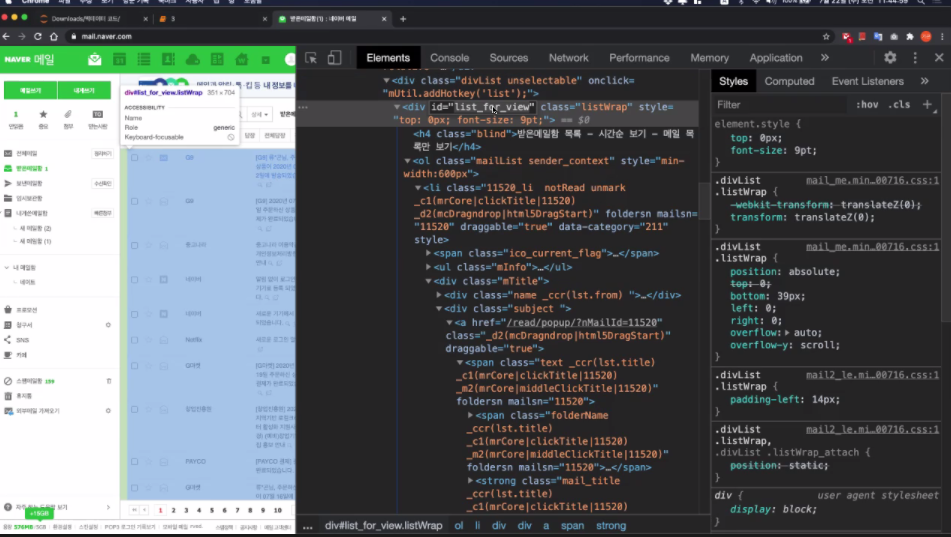

In [53]:
dom.select_one('#list_for_view')

In [54]:
mailapi = 'https://mail.naver.com/json/list/'
## params 연구해보기
params = {
    'page' : '2', ##
   ' sortField' : '1',
    'sortType' : '0',
    'folderSN' : '0',
    'type' : '',
    'isUnread' : 'false',
    'u' : 'ID'
}
resp = session.request('POST', mailapi, params=params)

In [55]:
resp.headers

{'Server': 'nginx', 'Date': 'Thu, 23 Jul 2020 00:39:52 GMT', 'Content-Length': '55', 'Connection': 'keep-alive', 'Keep-Alive': 'timeout=15', 'Set-Cookie': 'NID_AUT=expired; expires=Wed, 02-Jun-1999 00:00:00 GMT; path=/; domain=.naver.com;, NID_SES=expired; expires=Wed, 02-Jun-1999 00:00:00 GMT; path=/; domain=.naver.com;', 'P3P': 'CP="ALL CURa ADMa DEVa TAIa OUR BUS IND PHY ONL UNI PUR FIN COM NAV INT DEM CNT STA POL HEA PRE LOC OTC"', 'Vary': 'User-Agent,Accept-Encoding'}

In [2]:
for _ in resp.json()['mailData']:
    print(_['from'])
    print(_['subject'])
    print()

In [121]:
## 스팸메일함 들고오기

mailapi2 = 'https://mail.naver.com/json/list/'
params = {
    'page' : '1', 
   ' sortField' : '1',
    'sortType' : '0',
    'folderSN' : '5', ##
    'type' : '',
    'isUnread' : 'false',
    'u' : 'ljhee888'
}
resp = session.request('POST', mailapi2, params=params)

In [122]:
resp.headers

{'Server': 'nginx', 'Date': 'Wed, 22 Jul 2020 03:01:15 GMT', 'Content-Type': 'text/plain;charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Keep-Alive': 'timeout=15', 'Set-Cookie': 'NID_SES=AAABouFV1iLLT2p5JJonJ8QD+8XNXzORSlamP7sjE71q+SjbKDTLJsFkJurMc/LkajhSp/tQNVjnbaNawVE5QcyDYQ+XCjTIRVi0bK45oGkNsLAjKSzXRh77p5DCMETLgVOonMak+YhoTWnuKdSHt1vhCT3zSE8wrca+C5HhfpOX48FpDh3lEa0W6nd15pHVBdHJhVIgh9NB4nL5cIHXmCGdXAStHOjPk09J4f8n6moa7K83BGt91yiY0td+8XgUuiILhx4LpmR+D3hbuylVQ0DJbx4hBr1SwpZ8Tcn6S1x/WSE+6WluliLWS9hjTk+/7Md2XARf0nC2tegZ+yHOxk1WxbhOH6kxZ94NxBmplBoHCN+XhNC4keNn1Vu/jBsQ4EAQyDYGmpjmWxqQd+xGMi66tCzFt2HjP/K89bp+QUNRnl8b6c6ImSJl66+S0Owjc1a9sJMqAHYlMm3K2jLsQhWh9AAOqP72cW2jtcAkYOLjTp5d44Hi+jEBXVPnpd51s9UxCSX69t6aJsIcZwwB+kzWxfjyhMFhQixiQyf5oYnESHbMg4GVOMFfR9/X1rPjyWp9cg==; path=/; domain=.naver.com', 'Cache-Control': 'no-cache, no-store, max-age=0, must-revalidate', 'Pragma': 'no-cache', 'Expires': 'Thu, 01 Jan 1970 00:00:00 GMT', 'P3P': 'CP="ALL CURa ADMa DEVa TAIa O

In [123]:
for _ in resp.json()['mailData']:
    print(_['from'])
    print(_['subject'])
    print()

{'name': '빅데이터러닝센터', 'email': 'mail@datasolution.kr'}
[빅데이터 러닝센터](오픈소스)jamovi 기초통계분석 개설 안내 (7/39~31) (AD)

{'name': '빅데이터러닝센터', 'email': 'mail@datasolution.kr'}
[빅데이터러닝센터] &#39;자연어 처리 고급 과정, 최신 텍스트 임베딩 기법&#39; 교육 안내 (ad)

{'name': '청약당첨자', 'email': 'lotto99909@naver.com'}
(광고)안정적인 연 15% 수익이 정말 가능할까요?

{'name': '빅데이터러닝센터', 'email': 'mail@datasolution.kr'}
[빅데이터러닝센터] 8월 교육 뉴스 레터 발행 안내 (Python,R,Amos,메타분석,텍스트분석) (ad)

{'name': '빅데이터러닝센터', 'email': 'mail@datasolution.kr'}
[빅데이터러닝센터] &#39;텍스트분석을 활용하여 의미 있는 성과를 내보세요! e-러닝(입문과정), 현장강의(심화과정) &#39; 교육 안내 (ad)

{'name': '2천만원드림', 'email': 'mvp777777@naver.com'}
수도권복층오피 9,900

{'name': '빅데이터 러닝센터', 'email': 'mail@datasolution.kr'}
[빅데이터 러닝센터] (오픈소스) Orange S/W를 활용한 데이터과학 교육 개설 안내(7/22~23) (AD)

{'name': '빅데이터 러닝센터', 'email': 'mail@datasolution.kr'}
[빅데이터 러닝센터]우종필 교수의 Amos 구조방정식모형 분석 (7/16~17) (ad)

{'name': '빅데이터러닝센터', 'email': 'mail@datasolution.kr'}
[빅데이터러닝센터] &#39;SPSS Statistics 의학보건학 심화과정3 : 반복측정자료분석&#39; 교육 안내 (ad)

{'name': '동탄오피스텔9900', '

In [192]:
url = 'https://lms.sunde41.net/dashboard/'
resp = download(url)
dom = BeautifulSoup(resp.text, 'html.parser')

dom.form['action'], dom.form['method']
params = {}
for _ in dom.form.select('input[name]'):
    params[_['name']] = _['value'] if _.has_attr('value') else ''

import json
with open('lms.json') as f:
    account = json.load(f)
    
params['email'] = account['id']
params['password'] = account['pw']

session.cookies.clear()
resp = session.post(urljoin(url, dom.form['action']), data=params)

url = 'https://lms.sunde41.net/course/2'
resp = session.get(url)
dom = BeautifulSoup(resp.text, 'html.parser')

notice = dom.select_one('#notice-table tr:nth-of-type(1) td:nth-of-type(2)')

date = re.sub(r'(T.+)', '',
       notice.find_previous_sibling().span.text.strip())
addr = re.search(r'href="([^"]+)"', notice.decode()).group(1)
user = re.findall(r'\s+(\d+)<', notice.decode())

print('날짜: {}'.format(date));
print('주소: {}'.format(addr));
print('아이디 : {0} / 비밀번호 : {1}'.format(user[0], user[1]))


날짜: 2020-07-22
주소: https://us02web.zoom.us/j/82558845438?pwd=UkkzK0NPMFZkaEtTM1l2dCtLeDJidz09
아이디 : 82558845438 / 비밀번호 : 053625


In [ ]:
with open('lms.json') as f:
    account = json.load(f)

In [288]:
## 논문 리뷰 사이트
session.cookies.clear()
url = 'https://pubmed.ncbi.nlm.nih.gov/'
resp = download(url)
dom = BeautifulSoup(resp.text, 'html.parser')

In [289]:
# <form action="/" autocomplete="off" class="usa-search usa-search-big search-form" id="search-form" method="get" role="search">
dom.form

<form action="/" autocomplete="off" class="usa-search usa-search-big search-form" id="search-form" method="get" role="search">
<div class="inner-wrap">
<a aria-label="Pubmed Logo" class="pubmed-logo" data-ga-action="pubmed_logo" data-ga-category="featured_link" href="/"></a>
<a aria-label="Show search bar" class="search-input-trigger" data-alt-title="Hide search bar" href="#" title="Show search bar">
</a>
<div class="search-input" role="search">
<div class="form-field">
<label class="usa-sr-only" for="id_term">
    Search:
  </label>
<input class="term-input" data-exact-query="" id="id_term" name="term" placeholder="Search PubMed" required="required" type="search"/><a class="clear-btn" href="#" role="button" title="Clear search input"></a><button aria-label="Search" class="search-btn" data-pinger-ignore="" type="submit"><span class="usa-search-submit-text">Search</span></button>
</div>
</div>
<div class="search-links-wrapper">
<div class="search-links">
<a class="search-input-link adv-

In [290]:
dom.form['action'], dom.form['method'] 

('/', 'get')

In [291]:
dom.form.select('input[name]')

[<input class="term-input" data-exact-query="" id="id_term" name="term" placeholder="Search PubMed" required="required" type="search"/>]

In [292]:
params = dict()
for _ in dom.form.select('input[name]'):
    params[_['name']] = _['value'] if _.has_attr('value') else ''

In [293]:
params['term'] = 'COVID-19'

In [294]:
params

{'term': 'COVID-19'}

In [295]:
resp = download(urljoin(url, dom.form['action']),
                params=params, method=dom.form['method'].upper())
dom = BeautifulSoup(resp.text, 'html.parser')

In [296]:
for _ in dom.select('a.docsum-title'):
    print(urljoin(url, _['href']))
    print(_.text.strip())
    print()

https://pubmed.ncbi.nlm.nih.gov/32104915/
The neuroinvasive potential of SARS-CoV2 may play a role in the respiratory failure of COVID-19 patients.

https://pubmed.ncbi.nlm.nih.gov/32347054/
[Strategies for vaccine development of COVID-19].

https://pubmed.ncbi.nlm.nih.gov/32141569/
COVID-19 (Novel Coronavirus 2019) - recent trends.

https://pubmed.ncbi.nlm.nih.gov/32232980/
COVID-19 epidemic: Disease characteristics in children.

https://pubmed.ncbi.nlm.nih.gov/32096567/
Understanding of COVID-19 based on current evidence.

https://pubmed.ncbi.nlm.nih.gov/32134116/
Unique epidemiological and clinical features of the emerging 2019 novel coronavirus pneumonia (COVID-19) implicate special control measures.

https://pubmed.ncbi.nlm.nih.gov/32134278/
Perspectives on monoclonal antibody therapy as potential therapeutic intervention for Coronavirus disease-19 (COVID-19).

https://pubmed.ncbi.nlm.nih.gov/32380453/
What dentists need to know about COVID-19.

https://pubmed.ncbi.nlm.nih.gov/322

In [297]:
dom.find(text=re.compile(r'neuroinvasive')) # text 내에서 찾을 것들

'\n                The neuroinvasive potential of '

In [298]:
dom.find(text=re.compile(r'neuroinvasive')).find_parent()

<a class="docsum-title" data-article-id="32104915" data-full-article-url="from_term=COVID-19&amp;from_pos=1" data-ga-action="1" data-ga-category="result_click" data-ga-label="32104915" href="/32104915/" ref="linksrc=docsum_link&amp;article_id=32104915&amp;ordinalpos=1&amp;page=1">
                The neuroinvasive potential of <b>SARS</b>-CoV2 may play a role in the <b>respiratory</b> failure of <b>COVID</b>-<b>19</b> patients.
              </a>

In [299]:
# checklist
# dom.body, resp.text , resp.headers, resp.request.url, resp.request.headers

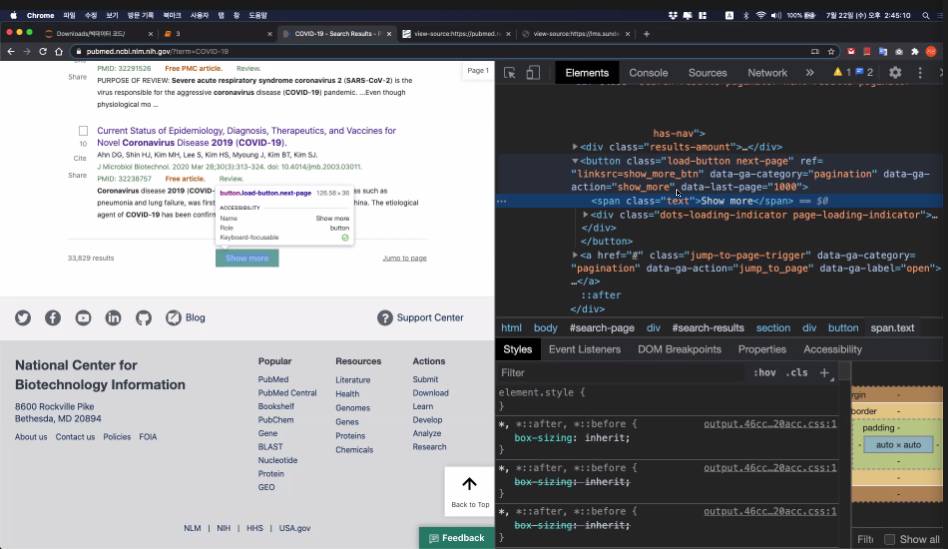

## more 때문에 추가작업 해 줘야 더 가져올 수 있다
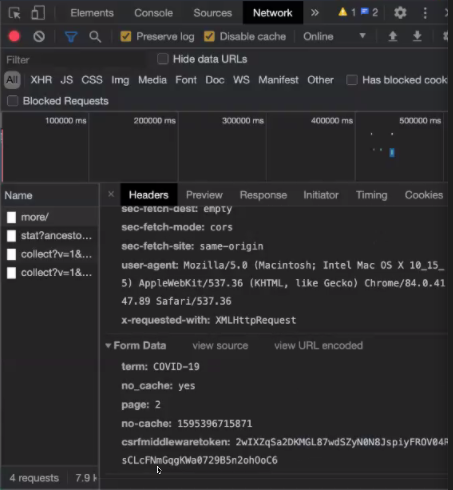

In [302]:
url = 'https://pubmed.ncbi.nlm.nih.gov/more/'
params={
    'term':'',
    'no_cache': 'yes',
    'page': 1,
    'no-cache': '1595396970989',
    'csrfmiddlewaretoken': 'wvI0qAI2POTGxLKmAGCMoL3MzJiZnWsn3cH6OrwWYYvw9QLWdRsiiYa7rIjZdumu'
}
params['term'] = 'COVID-19'

for page in range(1, 11):
    params['page'] = page

    resp = download(url, params, headers, 'POST')
    dom = BeautifulSoup(resp.text, 'html.parser')

    for _ in dom.select('a.docsum-title'):
        print(urljoin(url, _['href']))
        print(_.text.strip())
        print()

[Error] https://pubmed.ncbi.nlm.nih.gov/more/
https://pubmed.ncbi.nlm.nih.gov/32104915/
The neuroinvasive potential of SARS-CoV2 may play a role in the respiratory failure of COVID-19 patients.

https://pubmed.ncbi.nlm.nih.gov/32347054/
[Strategies for vaccine development of COVID-19].

https://pubmed.ncbi.nlm.nih.gov/32141569/
COVID-19 (Novel Coronavirus 2019) - recent trends.

https://pubmed.ncbi.nlm.nih.gov/32232980/
COVID-19 epidemic: Disease characteristics in children.

https://pubmed.ncbi.nlm.nih.gov/32096567/
Understanding of COVID-19 based on current evidence.

https://pubmed.ncbi.nlm.nih.gov/32134116/
Unique epidemiological and clinical features of the emerging 2019 novel coronavirus pneumonia (COVID-19) implicate special control measures.

https://pubmed.ncbi.nlm.nih.gov/32134278/
Perspectives on monoclonal antibody therapy as potential therapeutic intervention for Coronavirus disease-19 (COVID-19).

https://pubmed.ncbi.nlm.nih.gov/32380453/
What dentists need to know about 

In [243]:
## automate : session 이용!

session.cookies.clear()
resp = session.get('https://pubmed.ncbi.nlm.nih.gov/',
                   params={'term':'COVID-19'})
referer = resp.request.url

<Response [200]>

In [244]:
session.cookies.get_dict()
# resp.request.url

{'ncbi_sid': 'CE84001FF17D3693_8430SID',
 'pm-adjnav-sid': 'axtHvw5Dt2K4N54l7f-Gkg:fc3c2327825122295ca0f27af5d5c8e6',
 'pm-sid': 'SC6tXuNNYLTXEuaC0cw96Q:fc3c2327825122295ca0f27af5d5c8e6',
 'pm-csrf': 'zchhPwfVaIDKWpd3ojGRgY33QxbfPG3fKjJN7yCsk7XYAFqRDRiRYFxYKViEGdF5',
 'pm-sessionid': 'vyglkw13qkcegvanf919tnl8b2wa4mgc'}

In [249]:
';'.join([k+'='+v for k, v in session.cookies.get_dict().items()])

'ncbi_sid=CE84001FF17D3693_8430SID;pm-adjnav-sid=axtHvw5Dt2K4N54l7f-Gkg:fc3c2327825122295ca0f27af5d5c8e6;pm-sid=SC6tXuNNYLTXEuaC0cw96Q:fc3c2327825122295ca0f27af5d5c8e6;pm-csrf=zchhPwfVaIDKWpd3ojGRgY33QxbfPG3fKjJN7yCsk7XYAFqRDRiRYFxYKViEGdF5;pm-sessionid=vyglkw13qkcegvanf919tnl8b2wa4mgc'

In [245]:
# header_cookie = ';'.join([k+'='+v for k, v in session.cookies.get_dict().items()])
# header_referer = resp.request.url

In [246]:
resp.request.headers

{'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'referer': 'https://pubmed.ncbi.nlm.nih.gov/?term=COVID-19', 'cookie': 'pm-csrf=6JdoCIqdM6dmjiLIDNM9MzTEJ4XXxwCpDqcu0ze7VgPcVnMigYCFGM0ZB3YXn4ww; pm-sessionid=9ksv74926lv83nmdugxmdqnbdpdsogau; ncbi_sid=B7864860F17BE603_17959SID; _ga=GA1.2.1055876220.1595395895; _gid=GA1.2.2083294601.1595395895; pm-sid=usxiZSWYf0zrT5wDUFd7JQ:fc3c2327825122295ca0f27af5d5c8e6; pm-adjnav-sid=CLGoiSLlBhItAkbK9fNKmA:fc3c2327825122295ca0f27af5d5c8e6; ncbi_pinger=N4IgDgTgpgbg+mAFgSwCYgFwgMIDYBC+ADCQIwAc5AzAGKn4CsDJJATAKJX5Wm2kDsuAIIA6UiIC2cKiAC+QA===; pm-iosp=; _gat_ncbiSg=1', 'Content-Length': '141', 'Content-Type': 'application/x-www-form-urlencoded'}

In [305]:
# Header -> Referer, Token 둘다검사 -> Bot 체크
session.cookies.clear()
resp = session.get('https://pubmed.ncbi.nlm.nih.gov/',
                   params={'term':'COVID-19'})
dom = BeautifulSoup(resp.text, 'html.parser')
print('1페이지')
for _ in dom.select('a.docsum-title'):
    print(urljoin(url, _['href']))
    print(_.text.strip())
    print()
print()
referer = resp.request.url

params = {
    'term':'COVID-19',
    'no_cache':'yes',
    'page':1,
    'no-cache':'1595396715871',
    'csrfmiddlewaretoken':session.cookies.get('pm-csrf') ## check!!!
}

for page in range(2, 11):
    params['page'] = page
    
    resp = session.post('https://pubmed.ncbi.nlm.nih.gov/more/',
                        data=params, headers={'referer':referer})
    dom = BeautifulSoup(resp.text, 'html.parser')
    print('{}페이지'.format(page))
    for _ in dom.select('a.docsum-title'):
        print(urljoin(url, _['href']))
        print(_.text.strip())
        print()
    print()

1페이지
https://pubmed.ncbi.nlm.nih.gov/32104915/
The neuroinvasive potential of SARS-CoV2 may play a role in the respiratory failure of COVID-19 patients.

https://pubmed.ncbi.nlm.nih.gov/32347054/
[Strategies for vaccine development of COVID-19].

https://pubmed.ncbi.nlm.nih.gov/32141569/
COVID-19 (Novel Coronavirus 2019) - recent trends.

https://pubmed.ncbi.nlm.nih.gov/32232980/
COVID-19 epidemic: Disease characteristics in children.

https://pubmed.ncbi.nlm.nih.gov/32096567/
Understanding of COVID-19 based on current evidence.

https://pubmed.ncbi.nlm.nih.gov/32134116/
Unique epidemiological and clinical features of the emerging 2019 novel coronavirus pneumonia (COVID-19) implicate special control measures.

https://pubmed.ncbi.nlm.nih.gov/32134278/
Perspectives on monoclonal antibody therapy as potential therapeutic intervention for Coronavirus disease-19 (COVID-19).

https://pubmed.ncbi.nlm.nih.gov/32380453/
What dentists need to know about COVID-19.

https://pubmed.ncbi.nlm.nih.go

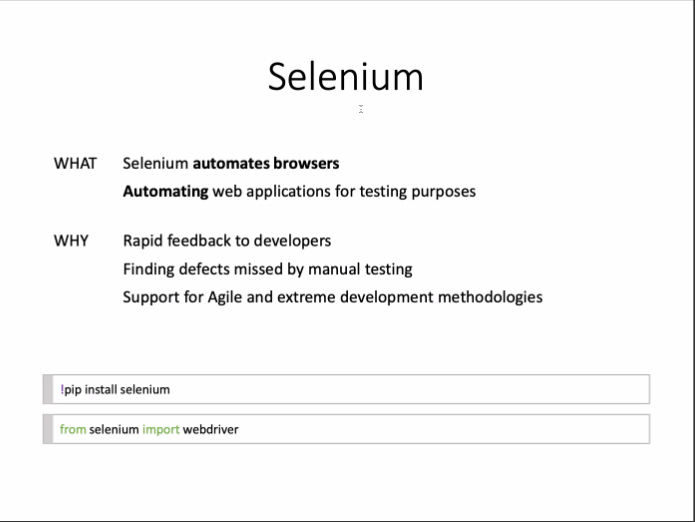

In [70]:
from selenium import webdriver
driver = webdriver.Chrome()
driver.get('http://www.naver.com')

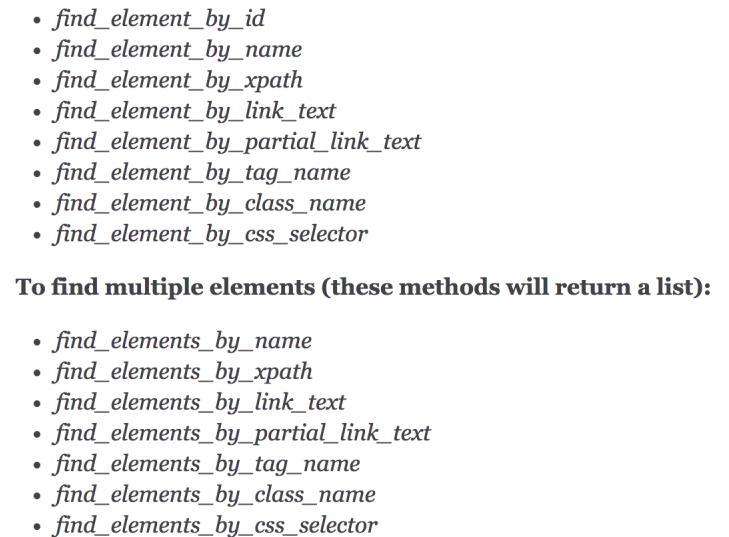

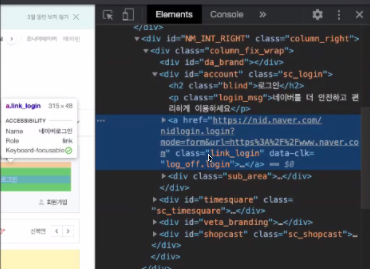

In [73]:
driver.find_element_by_class_name('link_login').text

'네이버\n로그인'

In [74]:
type(_) # bs4.element.Tag

bs4.element.Tag

In [75]:
dir(driver.find_element_by_class_name('link_login'))
# 'is_displayed','is_enabled','is_selected', : 자동화에 중요한 요소
# click, send_keys

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_execute',
 '_id',
 '_parent',
 '_upload',
 '_w3c',
 'clear',
 'click',
 'find_element',
 'find_element_by_class_name',
 'find_element_by_css_selector',
 'find_element_by_id',
 'find_element_by_link_text',
 'find_element_by_name',
 'find_element_by_partial_link_text',
 'find_element_by_tag_name',
 'find_element_by_xpath',
 'find_elements',
 'find_elements_by_class_name',
 'find_elements_by_css_selector',
 'find_elements_by_id',
 'find_elements_by_link_text',
 'find_elements_by_name',
 'find_elements_by_partial_link_text',
 'find_elements_by_tag_name',
 'find_elements_by_xpath',
 'get_attribute',
 'get_property',
 'id',
 

In [76]:
driver.find_element_by_class_name('link_login').click() # driver에서 변환

In [85]:
with open('account.json') as f:
    account = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'account.json'

In [78]:
# / -> root, . -> 현재위치
# / -> 자식
# // -> 자손
# [@class='속성']

In [79]:
driver.find_element_by_xpath('//input[@id="id"]') 

<selenium.webdriver.remote.webelement.WebElement (session="4fb587de099eaae691df23eaebc207ab", element="91e21b1d-6b3d-4ca1-9aa5-e59b3c235597")>

In [80]:
driver.find_element_by_xpath('//span/input') # span 바로 자식에 있는 input

<selenium.webdriver.remote.webelement.WebElement (session="4fb587de099eaae691df23eaebc207ab", element="91e21b1d-6b3d-4ca1-9aa5-e59b3c235597")>

In [81]:
driver.find_element_by_xpath('//span/input').tag_name,\
driver.find_element_by_xpath('//input[@id="id"]').tag_name 


('input', 'input')

In [82]:
## 교수님이 css_selector 선호
driver.find_element_by_xpath('//span/input').get_attribute('placeholder'),\
driver.find_element_by_xpath('//input[@id="id"]').get_attribute('placeholder'),\
driver.find_element_by_id('id').get_attribute('placeholder'),\
driver.find_element_by_css_selector('#id').get_attribute('placeholder')

('아이디', '아이디', '아이디', '아이디')

In [83]:
# driver.find_element_by_css_selector('input[type=submit][id]').get_attribute('id')

In [86]:
account = {"id" : "ID", "pw" : "PW"}

In [87]:
## 로그인 페이지에서 로그인 하는 과정
driver.find_element_by_xpath('//input[@id="id"]').clear() # 초기화
driver.find_element_by_xpath('//input[@id="id"]').send_keys(account['id'])
driver.find_element_by_id('pw').clear() # 초기화
driver.find_element_by_id('pw').send_keys(account['pw'])
driver.find_element_by_css_selector('input[type=submit][id]').click()
## 자동입력 방지 문자 뜸

In [355]:
# dom = BeautifulSoup(driver.page_source, 'html.parser')
# dom.select_one('#id').find_parent().find_parent().find_parent(
# ).find_parent() # 비밀번호 찾을때까지 부모 찾기 반복

In [88]:
for _ in driver.get_cookies():
    print(_['name'], _['value'])

NID_JKL TDYFyAcYyCORfFcIUs5W/zkSNz1eI6+9Yyqk4SIEaPI=
NID_SES AAABoJIjzn/ey5CJH8auXUcFvvsWB2WApG6f2yvl5ByrZYZGNzoXmzdafGSiZHyf+DTI9x347fryEJG4U/+r9RFhp30dUkgipT9xXJ9IZZZcLdkdwfpLwuSUpzZkKL/aN6t/KTN46/ckL0D1DjwHU5LtIT/zkWFZj6fTRPYGJ55zqTaa9Q8FlAxsbLbWyWyK7YF8nXRfbjItreGXJeBLmrZ+uBD6pO+ZrSAMhBK/qVqKpYJO3NuLkkIdjIdpQRn/dzgWs1JvVtAVSTqBSQ7mumvti/ToutkKyS5hw+xquURETIZ9zazUvhLz2RlUP0dzUz2tWmWHMEGn6OL5RaswypDMu8q4XOA7AXRuSB0T3myOLBpUeF/tLOJmB37TQH54ZIOvVlIOt4FxPJIrVZQSrkMEmDSc7oTTH/fQthdnoY4UoYHr9PVrjxf18pbQ44xWCatLwQvr7C1bYGtCswClzk4kjgg6ZF25rYu99kOmQh+fAqJzmrk7tQ8LjA8jS+kCbbiV07dqjdF4En2RDWQVl3ukf6NxQd7XiRJJCFnAp1Qndhfe
NID_AUT fT8XsdXqsgyVGSNz5uk6hP0rNwDeft9lIX7nUKGULJvmz4OvHPYHysUF3I1QGrLS
NNB 34QCMMLK3YMF6
nid_inf -1602352721
NRTK ag#all_gr#1_ma#-2_si#0_en#0_sp#0
NM_THEME_EDIT 
PM_CK_loc a7d09affd7f2122e54f3fefbc952f95abf70255943270c5e168e73c087e88c65


In [89]:
driver.get('http://mail.naver.com')

In [90]:
dom = BeautifulSoup(driver.page_source, 'html.parser')
dom.find(text=re.compile('면담')).find_parent().find_parent().find_parent()

<ul class="mInfo"><li class="_m1(mlCore|toggleCheckMail|13430|down) _c1(mlCore|toggleCheckMail|13430|click) _stopDefault"><input class="mCheck _checkList _m3(mlCore|toggleCheckMail|13430|over) _m1(mlCore|toggleCheckMail|13430|down) _k1(mlCore|toggleCheckMail|13430|keydown) _stopDefault" id="mailCheck_13430" name="" onclick='ccr(this, "lst.selectgot", event)' resend="" securityleveltype="NORMAL" type="checkbox" value=""/><label class="blind" for="mailCheck_13430">"데이터청년캠퍼스_9조, 프로젝트, 면담요청" 메일 선택</label></li><li class="important _m1(mlCore|doStop) _c1(mlCore|markMailSelf|13430|mark) _ccr(lst.mark) _stopDefault"><a href="#" onblur="$Element(this).removeClass('_starFocus')" onfocus="$Element(this).addClass('_starFocus')"><span class="spr icoImportant icoImportantOff" mailsn="13430"><span class="blind">중요메일로 표시하기</span></span></a></li><li class="read"><a class="spr icoRead yes _c1(mlCore|readMail|unread_conversation|13430) _stopDefault" href="#" title="읽은 메일"><span class="blind">읽은 메일</span>

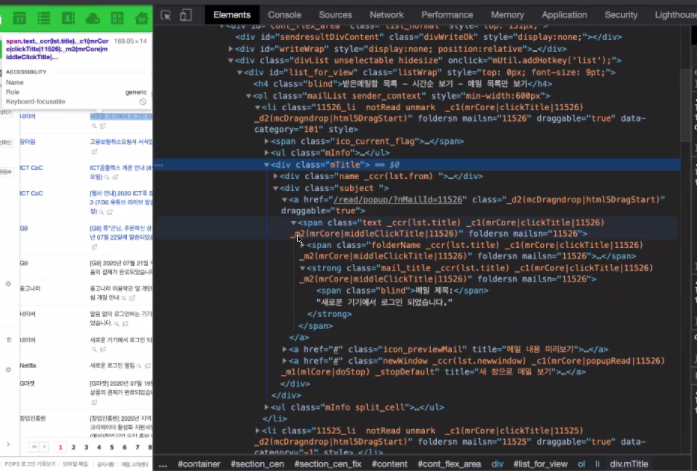

In [91]:
for _ in driver.find_elements_by_xpath('//ol//li//div[@class="mTitle"]'):
    print(_.text)

Steam Support
Your Steam account: Access from new computer
교보문고
(광고) [톡톡편지] 2020 상반기 독자의 선택은?
Facebook
이준희님, 새 알림 1개가 있습니다
Steam Support
Your Steam account: Access from new computer
중앙대학교 다빈치인..
RCI Financial Services Korea(르노캐피탈)｜Legal & Compliance Team 인턴사원
중앙대학교 다빈치인..
금강제화｜사무직 채용연계형 인턴사원
김박사넷
[🎓김박사뉴스#20] 아프니까 신입생이다😰
한국데이터산업진흥..
[D-8일] 2020 제2회 KOREA DATA-BIZ TRENDS 온라인 행사 안내
핫트랙스
(광고) ★세면대수전 5중필터 1만원대 최저가 무료배송!/ ★무선 키보드마우스 세트 15,900원 무배 /★폴레드 통풍시트 최저가!
Steam Support
Your Steam account: Access from new computer
Facebook
🎂 오늘은 최윤준님과 박민경님의 생일입니다
교보문고
(광고) 여름 홈캉스를 책임질 '프리미엄 홈카페 세트'를 드립니다! (가입 전원 사은품 증정)
Chaeyeon Kim
데이터청년캠퍼스_9조, 프로젝트, 면담요청
Goodreads
Goodreads Newsletter: July 21, 2020
ONOFFMIX
(광고)[온오프믹스 뉴스] '나'를 아끼는 현명한 습관, 7월 세번째 모임 소식!!


In [92]:
driver.close() # 작업 끝

In [ ]:
for k, v in cookiedict.items():
    driver.add_cookie({'name':k, 'value':v})

In [93]:
from selenium import webdriver
driver = webdriver.Chrome()

In [94]:
# 쿠키 셋팅
driver = webdriver.Chrome()

driver.get('http://www.naver.com')

for k, v in cookiedict.items():
    driver.add_cookie({'name':k, 'value':v, 'domain':'.naver.com'})

driver.get('http://www.naver.com')


In [95]:
# driver.delete_all_cookies()
driver_cookies = driver.get_cookies()
for _ in driver_cookies:
    driver.add_cookie(_)

In [100]:
driver.get('http://mail.naver.com')

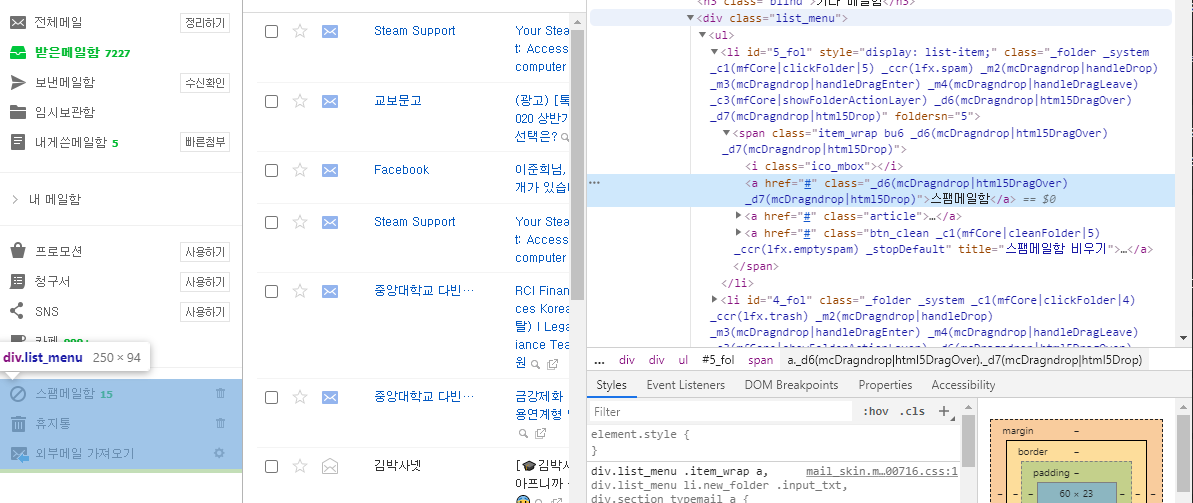

In [111]:
for _ in driver.find_elements_by_css_selector('div.list_menu'):
    print(_.text)

전체메일
정리하기
받은메일함
7227
보낸메일함
수신확인
임시보관함
내게쓴메일함
5
빠른첨부

프로모션
사용하기
청구서
사용하기
SNS
사용하기
카페
999+
스팸메일함
15
휴지통
외부메일 가져오기


In [113]:
menu = driver.find_elements_by_css_selector('div.list_menu')[-1]
menu.find_element_by_css_selector('a[href]').click()

In [114]:
for _ in driver.find_elements_by_xpath('//ol//li//div[@class="mTitle"]'):
    print(_.text)

빅데이터러닝센터
시스템차단
[빅데이터 러닝센터] 3일만에 익히는 R 기초통계분석 교육 개설 안내 (8/10~12) (AD)
빅데이터러닝센터
시스템차단
[빅데이터 러닝센터](오픈소스)jamovi 기초통계분석 개설 안내 (7/39~31) (AD)
빅데이터러닝센터
스팸자동이동
[빅데이터러닝센터] '자연어 처리 고급 과정, 최신 텍스트 임베딩 기법' 교육 안내 (ad)
청약당첨자
시스템차단
(광고)안정적인 연 15% 수익이 정말 가능할까요?
빅데이터러닝센터
스팸자동이동
[빅데이터러닝센터] 8월 교육 뉴스 레터 발행 안내 (Python,R,Amos,메타분석,텍스트분석) (ad)
빅데이터러닝센터
스팸자동이동
[빅데이터러닝센터] '텍스트분석을 활용하여 의미 있는 성과를 내보세요! e-러닝(입문과정), 현장강의(심화과정) ' 교육 안내 (ad)
2천만원드림
시스템차단
수도권복층오피 9,900
빅데이터 러닝센터
시스템차단
[빅데이터 러닝센터] (오픈소스) Orange S/W를 활용한 데이터과학 교육 개설 안내(7/22~23) (AD)
빅데이터 러닝센터
스팸자동이동
[빅데이터 러닝센터]우종필 교수의 Amos 구조방정식모형 분석 (7/16~17) (ad)
빅데이터러닝센터
스팸자동이동
[빅데이터러닝센터] 'SPSS Statistics 의학보건학 심화과정3 : 반복측정자료분석' 교육 안내 (ad)
동탄오피스텔9900
시스템차단
복층오피스텔9,900만원
동탄오피스텔9,900
시스템차단
(광고)동탄 남향 오피스텔 9,900
빅데이터 러닝센터
시스템차단
[빅데이터 러닝센터] 통계분석의 모든 것! 리서치와 통계분석 (SPSS 기초통계편) (7/8~9일) (AD)
빅데이터 러닝센터
시스템차단
[빅데이터 러닝센터] 메타분석의 이해와 활용 초급 및 중급과정 / 패키지 할인 (7/20~21, 7/27~28) (AD)
특별한 수익
시스템차단
역세권 잔금포함 투자금2,000 끝


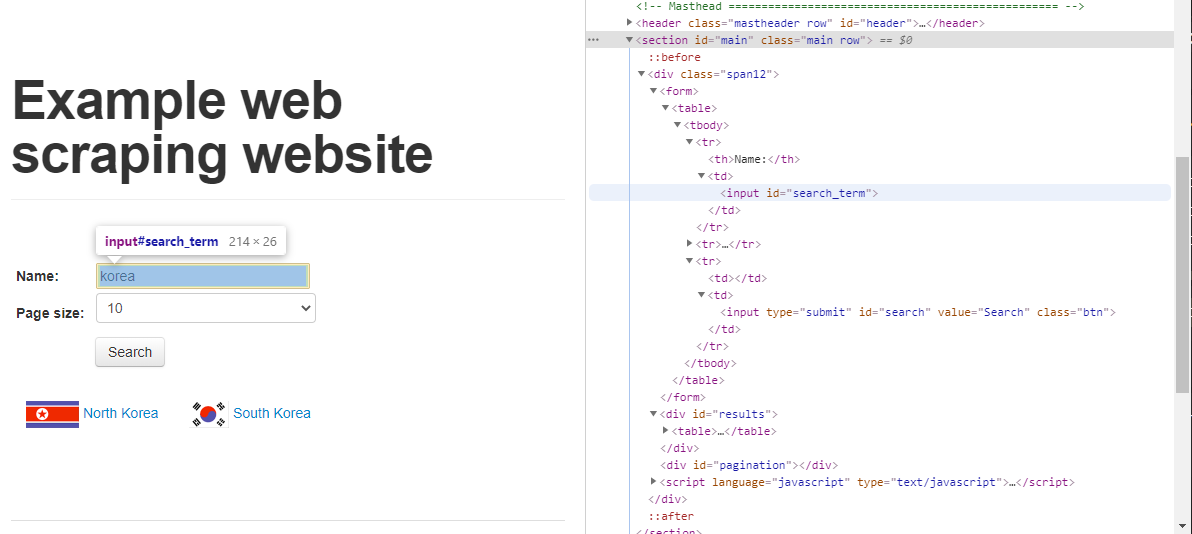

In [116]:
driver.get('http://example.webscraping.com/places/default/search')

In [117]:
driver.find_element_by_xpath('//input[@id="search_term"]').clear()
driver.find_element_by_xpath('//input[@id="search_term"]').send_keys('korea')   
driver.find_element_by_xpath('//input[@id="search"]').click()

In [120]:
driver.find_element_by_xpath('//div[@id="results"]').text

'North Korea\nSouth Korea'

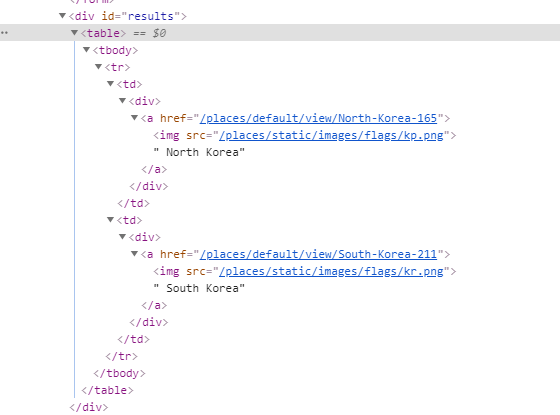

In [127]:
for _ in driver.find_elements_by_xpath('//div[@id="results"]//td/div'):
    print(_.find_element_by_css_selector('a').get_attribute('href'))
    print(_.find_element_by_css_selector('img').get_attribute('src'))
    print(_.find_element_by_css_selector('a').text.strip())
    print()

http://example.webscraping.com/places/default/view/North-Korea-165
http://example.webscraping.com/places/static/images/flags/kp.png
North Korea

http://example.webscraping.com/places/default/view/South-Korea-211
http://example.webscraping.com/places/static/images/flags/kr.png
South Korea



In [132]:
driver.get('https://pubmed.ncbi.nlm.nih.gov')

In [133]:
# driver.get_cookies() ## 'name': 'pm-csrf'

In [137]:
driver.find_element_by_id('id_term').clear()
driver.find_element_by_id('id_term').send_keys('COVID-19')
driver.find_element_by_class_name('search-btn').click() # 검색창 클릭

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":".results-amount + button"}
  (Session info: chrome=83.0.4103.116)


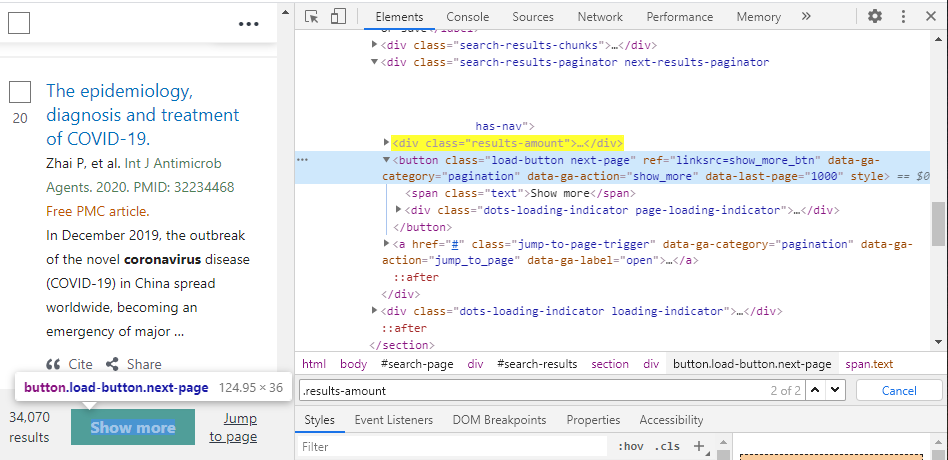

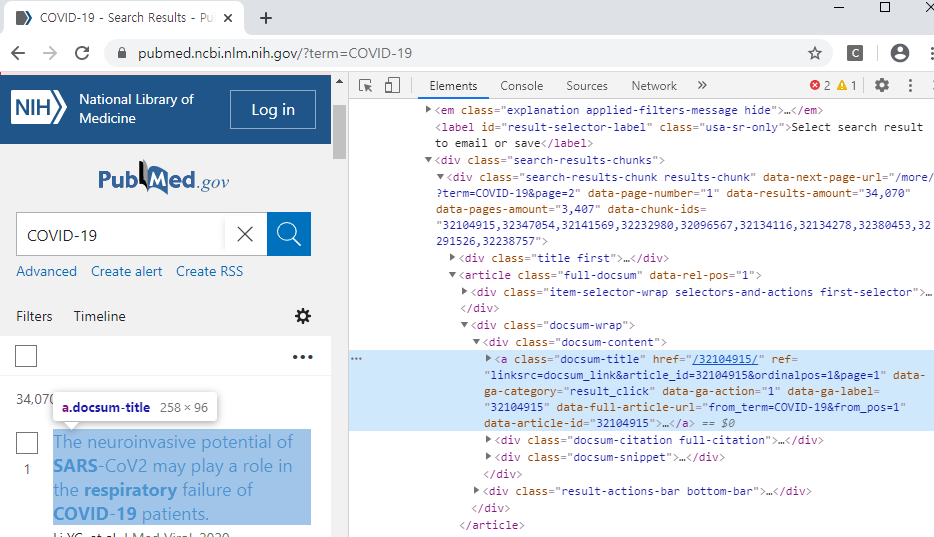

In [141]:
# show more 버튼
## 논문 리뷰 사이트에서 css_selector에서 .results-amount + button이 들어가는 이유 다시 설명해주실 수 있을까요??
for _ in range(4):
    sleep(1) # 정확히 1초 기다리라는 구문
    driver.find_element_by_css_selector('.results-amount + button').click()

In [144]:
# 논문 제목들
for _ in driver.find_elements_by_css_selector('a.docsum-title'):
    print(_.text)

The neuroinvasive potential of SARS-CoV2 may play a role in the respiratory failure of COVID-19 patients.
[Strategies for vaccine development of COVID-19].
COVID-19 (Novel Coronavirus 2019) - recent trends.
COVID-19 epidemic: Disease characteristics in children.
Understanding of COVID-19 based on current evidence.
Unique epidemiological and clinical features of the emerging 2019 novel coronavirus pneumonia (COVID-19) implicate special control measures.
Perspectives on monoclonal antibody therapy as potential therapeutic intervention for Coronavirus disease-19 (COVID-19).
What dentists need to know about COVID-19.
Outcomes in Patients with COVID-19 Infection Taking ACEI/ARB.
Current Status of Epidemiology, Diagnosis, Therapeutics, and Vaccines for Novel Coronavirus Disease 2019 (COVID-19).
Review of the Clinical Characteristics of Coronavirus Disease 2019 (COVID-19).
COVID-19: a review.
[Analysis of the pregnancy outcomes in pregnant women with COVID-19 in Hubei Province].
Coronavirus d

In [177]:
driver.get('http://mail.naver.com')

In [178]:
btn = driver.find_element_by_id('gnb_logout_button')
print(dir(btn))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_execute', '_id', '_parent', '_upload', '_w3c', 'clear', 'click', 'find_element', 'find_element_by_class_name', 'find_element_by_css_selector', 'find_element_by_id', 'find_element_by_link_text', 'find_element_by_name', 'find_element_by_partial_link_text', 'find_element_by_tag_name', 'find_element_by_xpath', 'find_elements', 'find_elements_by_class_name', 'find_elements_by_css_selector', 'find_elements_by_id', 'find_elements_by_link_text', 'find_elements_by_name', 'find_elements_by_partial_link_text', 'find_elements_by_tag_name', 'find_elements_by_xpath', 'get_attribute', 'get_property', 'id', 'is_displayed', 'is_enabled', 'is_selected', 'location

In [179]:
## btn.is_displayed() : 버튼 없으면 false, 생기면 True
btn.is_displayed(), btn.is_enabled() 

(False, True)

In [191]:
## error check
from selenium.common.exceptions import ElementNotVisibleException, TimeoutException
from selenium.common.exceptions import ElementNotInteractableException

In [187]:
try:
    btn.click() ## 나가지는 버튼
except (ElementNotVisibleException,
        ElementNotInteractableException) as e:
    print(e)

Message: element not interactable
  (Session info: chrome=83.0.4103.116)



In [ ]:
# error 났을 때 기다리게 하기
# implicitly -> 시간 단축에 도움!! wait.until()
# explicitly -> sleep(1)

In [182]:
from selenium.webdriver.support.ui import WebDriverWait

In [189]:
wait = WebDriverWait(driver, 5, 0.5, ElementNotVisibleException)

In [185]:
print(dir(wait))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_driver', '_ignored_exceptions', '_poll', '_timeout', 'until', 'until_not']


In [ ]:
wait.until()

In [192]:
try:
    sleep(5) 
    print(btn.is_displayed(), btn.is_enabled())
except (ElementNotVisibleException,## 진짜로 눈에 안 보일때(있으나, 가려진 경우)
        ElementNotInteractableException) as e: ## 코드에는 있으나 화면에 없을 때
    print(e)

True True


In [194]:
try:
    # not True일때까지, 이 경우 창이 뜰때까지 기다리는거다
    #  -> 창 뜨면 5초 안기다리고 바로 출력
    wait.until(lambda d:d.find_element_by_id('gnb_logout_button').is_displayed()) 
    print(btn.is_displayed(), btn.is_enabled())
except (ElementNotVisibleException, 
        ElementNotInteractableException, 
        TimeoutException) as e:
    print(e)

True True


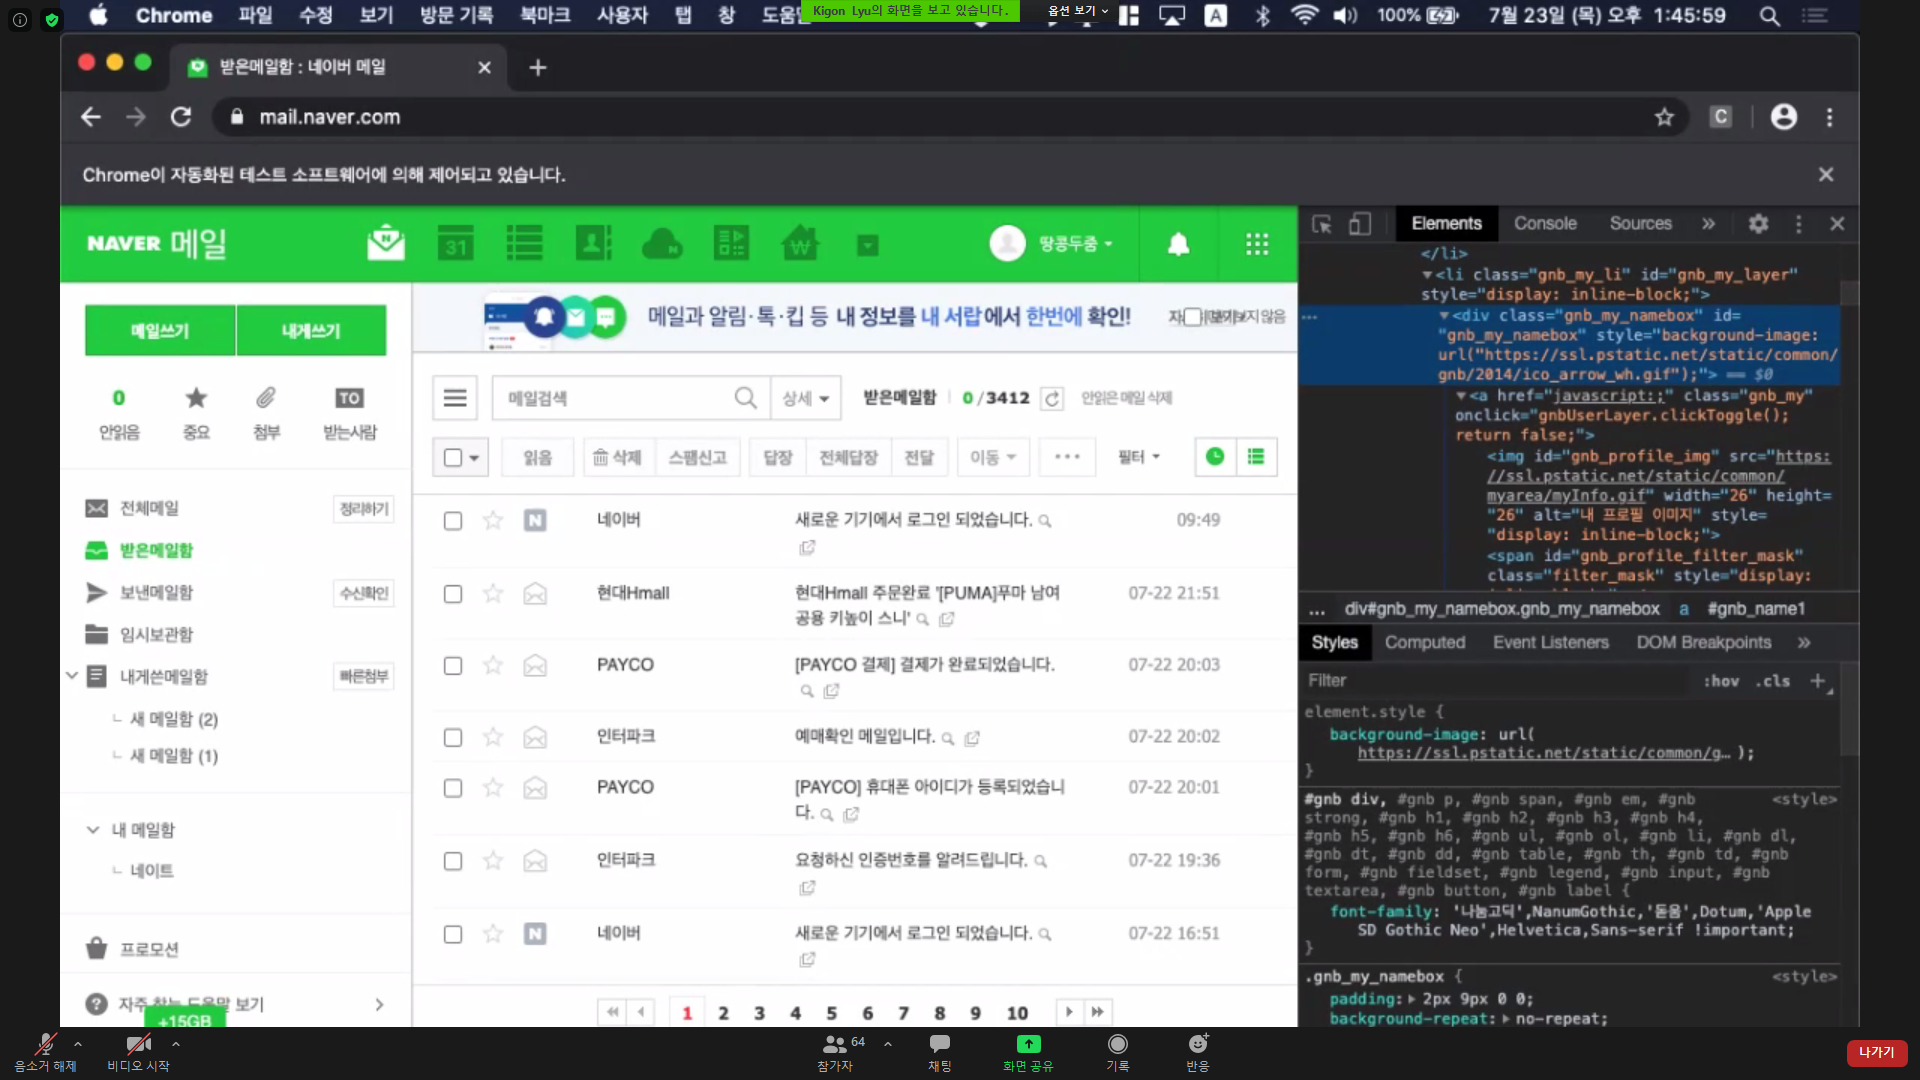

## StaleElementReferenceException이 생기는 이유
### button을 다시 만들어주자!
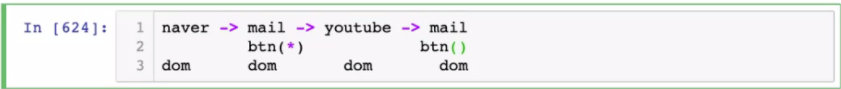

In [237]:
btn = driver.find_element_by_id('gnb_logout_button')

In [238]:
try:
    # not True일때까지, 이 경우 창이 뜰때까지 기다리는거다
    #  -> 창 뜨면 5초 안기다리고 바로 출력
    wait.until(lambda d:d.find_element_by_id('gnb_logout_button')\
               .is_displayed()) 
    print(btn.is_displayed(), btn.is_enabled())
except TimeoutException as e:
    print('창안뜸')
    driver.find_element_by_css_selector('#gnb_my_namebox > a').click()
    print(btn.is_displayed(), btn.is_enabled())
    

True True


In [243]:
# driver.switch_to_frame(driver.find_element('iframe')) : ??

In [244]:
driver.window_handles ## 어떤 dom 사용하고 있는지
driver.switch_to_window(driver.window_handles[0]) # dom 교체!

C:\Users\USER\miniconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: use driver.switch_to.window instead
  


In [241]:
driver.switch_to_window(driver.window_handles[0]) # dom 교체!

C:\Users\USER\miniconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: use driver.switch_to.window instead
  """Entry point for launching an IPython kernel.


In [195]:
## cf. JS를 실행하게 해줌
driver.execute_script('console.log("hi")')

### 결과
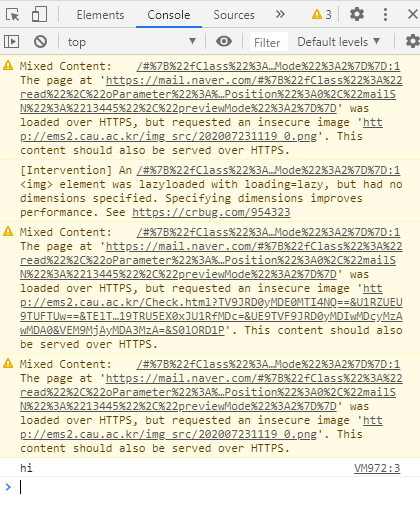